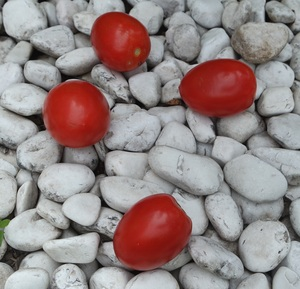

In [28]:
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# 0) Leer imagen
imagen = cv2.imread('imagen_examen.jpg')
cv2_imshow(imagen)

# 1) Número de clusters
k = 6

# 2) Obtenemos componenetes
blue = imagen[:,:,0]
green = imagen[:,:,1]
red = imagen[:,:,2]

# 3) Inicializar centroides
p_centroides = [[29, 45, 165], [222, 246, 197], [25, 94, 201], [52, 84, 44], [98, 20, 22], [72, 98, 124]]
"""
p_centroides = []
np.random.seed(12)

for n in range(k):
  centroide = list( np.random.randint(0,256,3) )
  p_centroides.append(centroide)

print(p_centroides)
"""
def errores(centroide, punto):
  (xc, yc, zc) = centroide
  (xp, yp, zp) = punto

  s1 = (xp - xc) **2
  s2 = (yp - yc) **2
  s3 = (zp - zc) **2

  return np.sqrt(s1+s2+s3)

def enlazarCentroide(pixel, centroides):
  lista_errores = []

  for o in range(k):
    error = errores(centroides[o], pixel)
    lista_errores.append(error)
  
  elegido = min(lista_errores)

  for u in range(k):
    if(elegido == lista_errores[u]):
      centroide_elegido = u

  return centroide_elegido

#Copias
azul = blue
verde = green
rojo = red

def asociar(lista_centroides):

  #Matriz con centroides

  (tx, ty) = blue.shape

  matriz_asigandos = np.zeros((tx, ty)) #Matriz del tamaño de la imagen

  for i in range(tx):
    for j in range(ty):
      
      pixel = [ blue[i,j], green[i,j], red[i,j] ]
      seleccionado = enlazarCentroide(pixel, lista_centroides)
      matriz_asigandos[i,j] = seleccionado 

  return matriz_asigandos

def actualizar(centroides_asignados, lista_cetr):

  (px, py) = blue.shape

  # 5) Actualizar centroides
  for ncentro in range(k):

    #Medias de las coordenadas
    media_b = [] 
    media_g = [] 
    media_r = [] 

    for i in range(px):
      for j in range(py):

        if(centroides_asignados[i,j] == ncentro):
          media_b.append(blue[i,j])
          media_g.append(green[i,j])
          media_r.append(red[i,j])
    
    if(media_b): 
      mb = np.mean(media_b)
      mg = np.mean(media_g)
      mr = np.mean(media_r)
    else:
      mb, mg, mr = lista_cetr[ncentro]

    lista_cetr[ncentro] = [mb, mg, mr]

  return lista_cetr

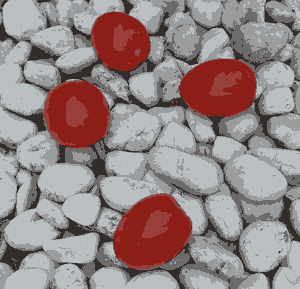

In [29]:
(tx, ty) = blue.shape

anterior = np.zeros((tx, ty))
nuevo = np.ones((tx, ty))

while(np.array_equal(nuevo,anterior) == False):

  anterior = nuevo

  #Envia lista con centroides y devuelve matriz con centroides asignados
  mcentroides_asignados = asociar(p_centroides) 

  nuevo = mcentroides_asignados

  #Devuelve lista de los centroides con posiciones actualizadas
  p_centroides = actualizar(mcentroides_asignados, p_centroides)


asignacion_final = mcentroides_asignados #Matriz con centroides asignados final
centroides_final = p_centroides          #Lista de las coord de los centroides en el centro de su cluster


# 6) Media de los colores
(tx, ty) = blue.shape

media_colores = []

for tam in range(k):
  media_colores.append([255,255,255])

for centroide_n in range(k):

  #Medias
  media_b = []
  media_g = []
  media_r = []

  for i in range(tx):
    for j in range(ty):

      if(asignacion_final[i,j] == centroide_n):
        media_b.append(blue[i,j])
        media_g.append(green[i,j])
        media_r.append(red[i,j])
  
  #if(media_b): 
  mb = np.mean(media_b)
  mg = np.mean(media_g)
  mr = np.mean(media_r)
  #else:
    #mb, mg, mr = centroides_final[ncentro]
    
  media_colores[centroide_n] = [mb, mg, mr] #Lista con la media correspondiente al color de cada cluster

# 7) Asignar colores
for k_centroide in range(k):

  for r in range(tx):
    for s in range(ty):

      if(asignacion_final[r,s] == k_centroide):
        azul[r,s], verde[r,s], rojo[r,s] = media_colores[k_centroide] #En las copias, actualizar color 

# 8) Crear la nueva imagen
nimagen = np.zeros((tx, ty, 3), dtype=np.uint8)

nimagen[:,:,0] = azul
nimagen[:,:,1] = verde
nimagen[:,:,2] = rojo

cv2_imshow(nimagen)

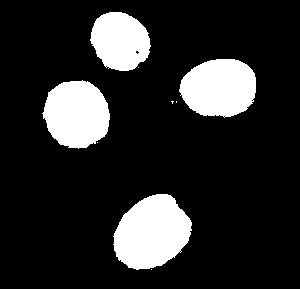

In [300]:
#Buscamos en la media de los colores, los centroides que tengan la tonalidad de los objetos a separar

tonos_rojos = []

for z in range(k):

  (b,g,r) = media_colores[z]

  if(r > 100 and g < 100 and b < 100): #Corresponde a diferentes medias de rojo
    tonos_rojos.append(z)


#Creamos una nueva imagen de 1 canal para esos objetos que tengan los centroides identificados con esa tonalidad
objetos_rojos = np.zeros((tx, ty), dtype=np.uint8)

for i in range(tx):
  for j in range(ty):

    for c in tonos_rojos:

      if(asignacion_final[i,j] == c):
        objetos_rojos[i,j] = 255

cv2_imshow(objetos_rojos)


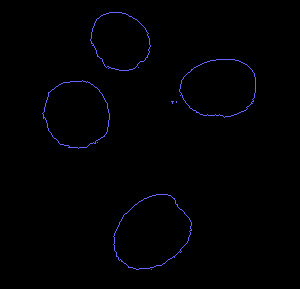

In [301]:
contornos1,hierarchy1 = cv2.findContours(objetos_rojos, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
nueva = np.zeros((tx, ty,3), dtype=np.uint8)

cv2.drawContours(nueva, contornos1, -1, (255,100,100), 1)

cv2_imshow(nueva)

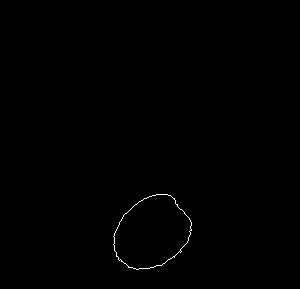

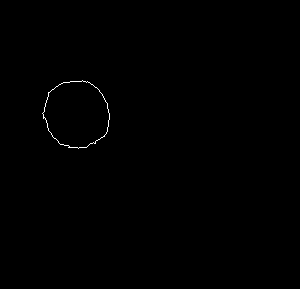

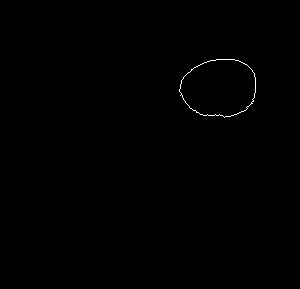

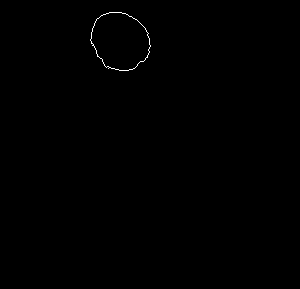

In [302]:
contornos_finales = []

j1 = np.zeros((tx, ty), dtype=np.uint8)
j2 = np.zeros((tx, ty), dtype=np.uint8)
j3 = np.zeros((tx, ty), dtype=np.uint8)
j4 = np.zeros((tx, ty), dtype=np.uint8)

#Observamos que tenemos contornos que no corresponden a un objeto, los discriminamos
for t in range(len(contornos1)):
  if(len(contornos1[t]) > 100):
    contornos_finales.append(contornos1[t])

cv2.drawContours(j1, contornos_finales, 0, 255, 1)
cv2.drawContours(j2, contornos_finales, 1, 255, 1)
cv2.drawContours(j3, contornos_finales, 2, 255, 1)
cv2.drawContours(j4, contornos_finales, 3, 255, 1)

cv2_imshow(j1)
cv2_imshow(j2)
cv2_imshow(j3)
cv2_imshow(j4)

Punto A:  (124, 252)
Punto B:  (173, 212)


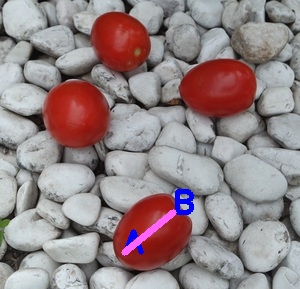

Distancia:  49.02040391510457


In [372]:
imagen = cv2.imread("imagen_examen.jpg")

contorno_uno = contornos_finales[0]

a1 = tuple(contorno_uno[contorno_uno[:, :, 0].argmin()][0])
b1 = tuple(contorno_uno[contorno_uno[:, :, 0].argmax()][0])
c1 = tuple(contorno_uno[contorno_uno[:, :, 1].argmin()][0])
d1 = tuple(contorno_uno[contorno_uno[:, :, 1].argmax()][0])


mediax_p1 = (a1[0] + d1[0]) / 2
mediay_p1 = (a1[1] + d1[1]) / 2

mediax_p2 = (c1[0] + b1[0]) / 2
mediay_p2 = (c1[1] + b1[1]) / 2

media_p1 = (int(mediax_p1), int(mediay_p1))
media_p2 = (int(mediax_p2), int(mediay_p2))

print('Punto A: ', media_p1)
print('Punto B: ', media_p2)


font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(imagen, "A", media_p1, font, 1, (255, 0, 0), 3)
cv2.putText(imagen, "B", media_p2, font, 1, (255, 0, 0), 3)

cv2.line(imagen,media_p1,media_p2,(255,100,255),5)

cv2_imshow(imagen)

(x1,y1) = media_p1
(x2,y2) = media_p2

p1 = (x2-x1)**2
p2 = (y2-y1)**2

distancia = np.sqrt(p1++2)

print('Distancia: ', distancia)

Punto A:  (179, 89)
Punto B:  (255, 92)


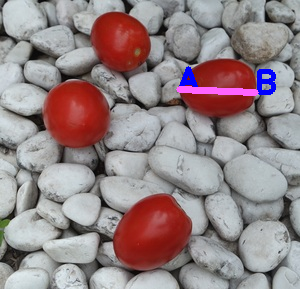

Distancia:  76.01315675591957


In [373]:
imagen = cv2.imread("imagen_examen.jpg")

contorno_dos = contornos_finales[2]

a2 = tuple(contorno_dos[contorno_dos[:, :, 0].argmin()][0])
b2 = tuple(contorno_dos[contorno_dos[:, :, 0].argmax()][0])

print('Punto A: ', a2)
print('Punto B: ', b2)


font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(imagen, "A", a2, font, 1, (255, 0, 0), 3)
cv2.putText(imagen, "B", b2, font, 1, (255, 0, 0), 3)

cv2.line(imagen,a2,b2,(255,100,255),5)

cv2_imshow(imagen)

(x1,y1) = a2
(x2,y2) = b2

p1 = (x2-x1)**2
p2 = (y2-y1)**2

distancia = np.sqrt(p1++2)

print('Distancia: ', distancia)
